In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# -------------------------
# Config
# -------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQ_LEN = 50
BATCH_SIZE = 32
EPOCHS = 20
P = 3  # number of correlated sensors including target
TARGET_SENSOR = "P1_PS_UP"
MODEL_SAVE_PATH = "lstm_autoencoder_corr.pth"

# -------------------------
# 1. Load Data
# -------------------------
df = pd.read_csv(r"G:\GlitchDetect\Temporal_models\100_hr_fault.csv")

# Select target + next P-1 correlated sensors
target_idx = df.columns.get_loc(TARGET_SENSOR)
start_idx = target_idx
end_idx = min(target_idx + P, df.shape[1])
selected_sensors = df.columns[start_idx:end_idx]
print("Selected sensors:", selected_sensors)

values = df[selected_sensors].values.astype(float)

# -------------------------
# 2. Normalize
# -------------------------
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

# -------------------------
# 3. Create Sequences
# -------------------------
def create_sequences(data, seq_len):
    xs = []
    for i in range(len(data) - seq_len):
        xs.append(data[i:(i+seq_len)])
    return np.array(xs)

X = create_sequences(scaled, SEQ_LEN)

# Train/test split
train_size = int(0.7 * len(X))
X_train, X_test = X[:train_size], X[train_size:]

torch_X_train = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
torch_X_test = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

train_dataset = TensorDataset(torch_X_train, torch_X_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# -------------------------
# 4. LSTM Autoencoder
# -------------------------
class LSTMAutoencoder(nn.Module):
    def __init__(self, n_features, hidden_dim=64, seq_len=SEQ_LEN):
        super(LSTMAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        
        self.encoder = nn.LSTM(input_size=n_features, hidden_size=hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(input_size=hidden_dim, hidden_size=hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, n_features)
    
    def forward(self, x):
        _, (hidden, _) = self.encoder(x)
        hidden_repeated = hidden.repeat(self.seq_len, 1, 1).permute(1,0,2)
        decoded, _ = self.decoder(hidden_repeated)
        out = self.output_layer(decoded)
        return out

n_features = X.shape[2]
model = LSTMAutoencoder(n_features).to(DEVICE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -------------------------
# 5. Train
# -------------------------
for epoch in range(EPOCHS):
    model.train()
    losses = []
    for batch_x, _ in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_x)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {np.mean(losses):.6f}")

# -------------------------
# 6. Save model & scaler
# -------------------------
torch.save(model.state_dict(), MODEL_SAVE_PATH)
import joblib
joblib.dump(scaler, "scaler_corr.pkl")
print("Model and scaler saved.")


Selected sensors: Index(['P1_PS_UP', 'P1_TS_DN', 'P1_TS_UP'], dtype='object')
Epoch 1/20, Loss: 0.001013
Epoch 2/20, Loss: 0.000878
Epoch 3/20, Loss: 0.000876
Epoch 4/20, Loss: 0.000870
Epoch 5/20, Loss: 0.000860
Epoch 6/20, Loss: 0.000856
Epoch 7/20, Loss: 0.000856
Epoch 8/20, Loss: 0.000856
Epoch 9/20, Loss: 0.000856
Epoch 10/20, Loss: 0.000856
Epoch 11/20, Loss: 0.000856
Epoch 12/20, Loss: 0.000856
Epoch 13/20, Loss: 0.000856
Epoch 14/20, Loss: 0.000856
Epoch 15/20, Loss: 0.000856
Epoch 16/20, Loss: 0.000856
Epoch 17/20, Loss: 0.000856
Epoch 18/20, Loss: 0.000856
Epoch 19/20, Loss: 0.000849
Epoch 20/20, Loss: 0.000838
Model and scaler saved.


C:\Users\adith\AppData\Local\Temp\ipykernel_10312\430519945.py:45: RuntimeWarning: invalid value encountered in divide
  reconstructed /= counts[:, None]


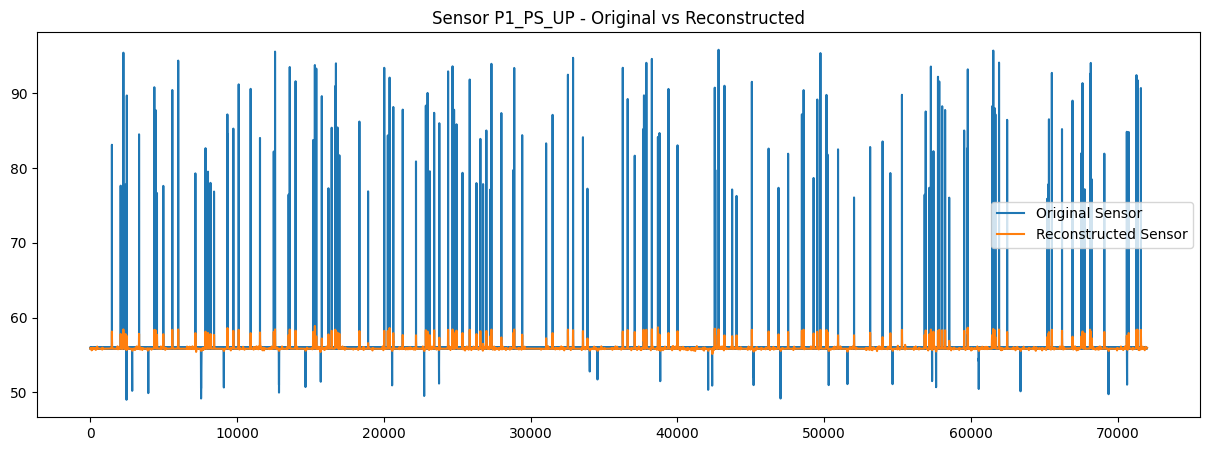

In [3]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEQ_LEN = 50
TARGET_SENSOR = "P1_PS_UP"
P = 3

# Load new data
df_new = pd.read_csv(r"G:\GlitchDetect\Temporal_models\100_hr_fault.csv")
target_idx = df_new.columns.get_loc(TARGET_SENSOR)
start_idx = target_idx
end_idx = min(target_idx + P, df_new.shape[1])
selected_sensors = df_new.columns[start_idx:end_idx]

values_new = df_new[selected_sensors].values.astype(float)

# Load scaler
import joblib
scaler = joblib.load("scaler_corr.pkl")
scaled_new = scaler.transform(values_new)

# Load model
n_features = scaled_new.shape[1]
model = LSTMAutoencoder(n_features).to(DEVICE)
model.load_state_dict(torch.load("lstm_autoencoder_corr.pth", map_location=DEVICE))
model.eval()

# Time-aligned reconstruction
reconstructed = np.zeros_like(scaled_new)
counts = np.zeros(len(scaled_new))

with torch.no_grad():
    for i in range(len(scaled_new) - SEQ_LEN):
        seq = scaled_new[i:i+SEQ_LEN]
        seq_tensor = torch.tensor(seq[None,:,:], dtype=torch.float32).to(DEVICE)
        recon_seq = model(seq_tensor).cpu().numpy()[0]
        reconstructed[i:i+SEQ_LEN] += recon_seq
        counts[i:i+SEQ_LEN] += 1

reconstructed /= counts[:, None]

# Plot target sensor
sensor_idx = 0  # first column of selected sensors
original_sensor_units = scaler.inverse_transform(scaled_new)[:, sensor_idx]
reconstructed_sensor_units = scaler.inverse_transform(reconstructed)[:, sensor_idx]

plt.figure(figsize=(15,5))
plt.plot(original_sensor_units, label="Original Sensor")
plt.plot(reconstructed_sensor_units, label="Reconstructed Sensor")
plt.title(f"Sensor {selected_sensors[sensor_idx]} - Original vs Reconstructed")
plt.legend()
plt.show()


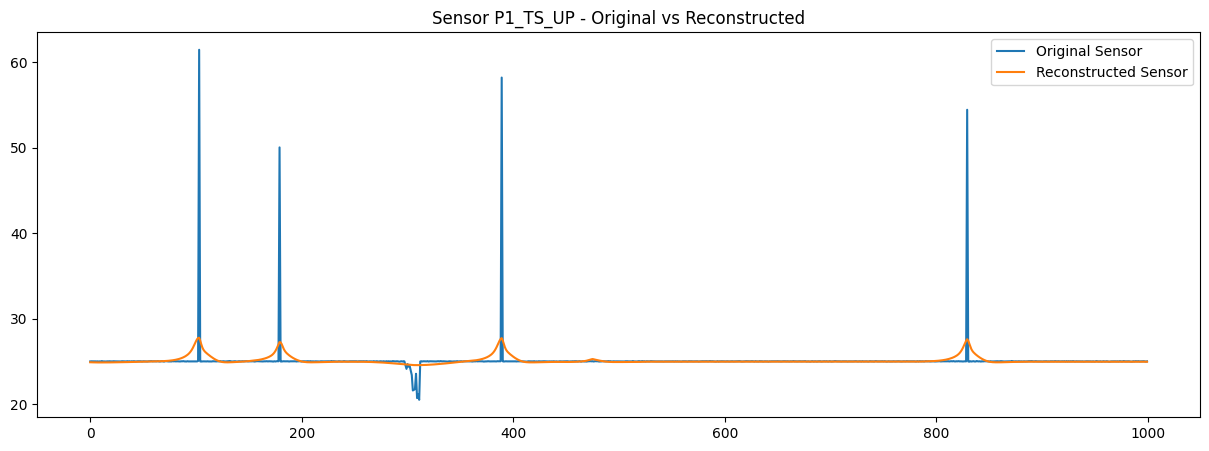

In [8]:
sensor_idx = 2  # first column of selected sensors
original_sensor_units = scaler.inverse_transform(scaled_new)[:, sensor_idx]
reconstructed_sensor_units = scaler.inverse_transform(reconstructed)[:, sensor_idx]

plt.figure(figsize=(15,5))
plt.plot(original_sensor_units[:1000], label="Original Sensor")
plt.plot(reconstructed_sensor_units[:1000], label="Reconstructed Sensor")
plt.title(f"Sensor {selected_sensors[sensor_idx]} - Original vs Reconstructed")
plt.legend()
plt.show()

In [ ]:
#apply PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform()

#plot ppc over time
plt.figure(figsize=(15,5))
plt.plot(reduced[:, 0], label="PCA Component 1")
plt.plot(reduced[:, 1], label="PCA Component 2")
plt.title("PCA Components Over Time")
plt.legend()
plt.show()

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values